In [2]:
""" Calibration and color segmentation of copepod microscope images

Usage:
======
    1. Read images and intercalibrate RGB channels
    - Read a given dataset ang display original images [X]
    - Zoom and/or avoid dark parts from the microscope or part of the petri box [not done yet]
    - Calibrate images without segmentation (using the median) [not working]
    - Save modified images [X]
    
    2. Apply color deconvolution method 
    - Construct color deconvolution matrix [X]
    - Apply it on all calibrated images [X]
    - Display astaxanthin OD levels and save images [X]
     
    3. Normalise optical density (OD) levels, corresponding to astaxanthin RGB intensity, between images
    - Compute max and min OD levels accross all tested images [X]
    - Correct  obtain a value between 0 and 1 [X]
    - Find a threshold and identify red pixels [X]
    - Display and save images [X]
     
"""

__authors__ = ("Laure Vilgrain", "Jean-Olivier Irisson", "Simon-Martin Schröder")
__contact__ = ("laure.vilgrain@imev-mer.fr", "irisson@normalesup.org", "sms@informatik.uni-kiel.de")
__version__ = "1.0.0"
__date__ = "04-2021"

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import statistics as stat
from matplotlib import pyplot as plt
from skimage import io, data, color, exposure, feature, morphology, measure
from scipy import ndimage as ndi
import copy

from skimage.io import imread
from skimage.color.colorconv import separate_stains, gray_from_rgb, yuv_from_rgb, yiq_from_rgb, rgb_from_hed, hed_from_rgb
from scipy import linalg
from skimage.filters import threshold_otsu
from matplotlib.colors import hex2color, rgb2hex

# 1. Read images and intercalibrate RGB channels
    - Read a given dataset ang display original images [x]
    - Zoom and/or avoid dark parts from the microscope or part of the petri box [not done yet]
    - Calibrate images without segmentation (using the median) [not working]
    - Save modified images [x]

## 1.1. Read a given dataset ang display original images

Original images


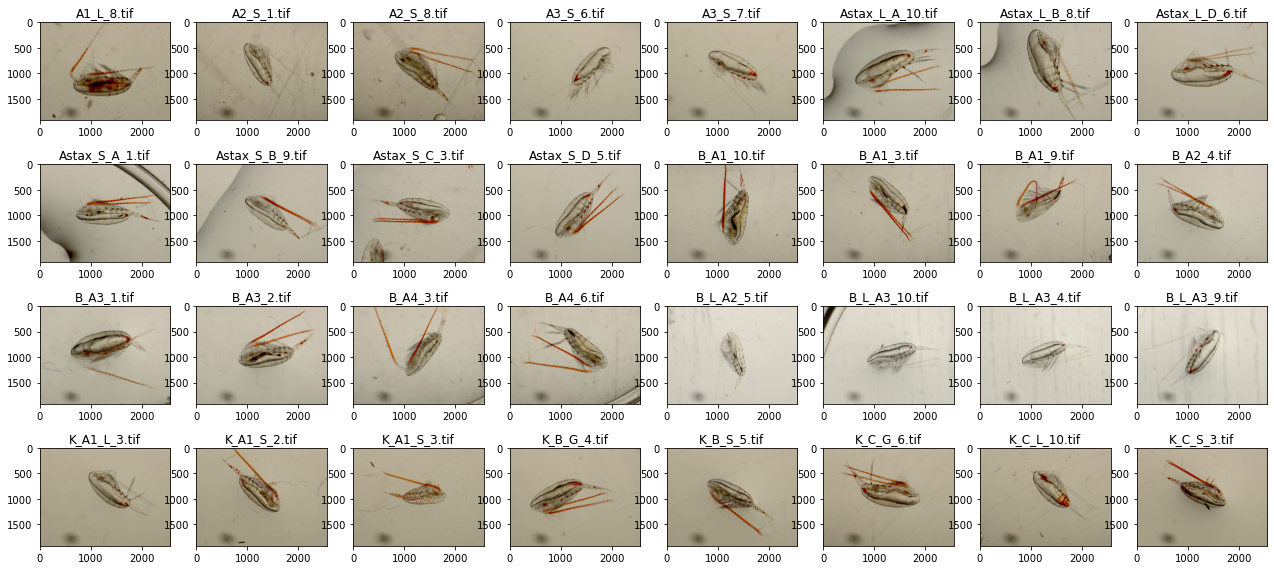

Average original RGB value: 166.20805089950562 , standard deviation: 19.54411069209802 , median: 168.54192209879557
---
RGB average for the background only (see code 1.segment_calibrate_method): [157.6, 154.4, 150.1, 168.6, 168.5, 162.3, 165.8, 171.9, 160.7, 171.4, 169.7, 173.6, 171.3, 169.9, 170.9, 182.3, 176.8, 178.1, 175.1, 174.6, 207.0, 201.5, 205.2, 204.1, 159.7, 158.7, 160.1, 162.1, 160.6, 160.0, 158.2, 160.5
---
List of RGB medians:  [157.0, 154.0, 149.0, 170.0, 170.0, 163.0, 166.0, 172.0, 165.0, 171.0, 171.0, 173.0, 171.0, 170.0, 171.0, 181.0, 176.0, 179.0, 175.0, 175.0, 207.0, 203.0, 205.0, 204.0, 161.0, 159.0, 163.0, 163.0, 159.0, 159.0, 158.0, 159.0]
---
List of RGB average for the entire image:  [148.5 152.3 144.8 166.2 165.6 157.1 160.  166.3 155.5 167.6 164.5 168.4
 164.7 165.  166.5 176.6 169.7 173.4 171.1 168.8 204.8 198.1 202.1 199.8
 156.4 153.9 156.9 156.1 154.8 153.9 155.  154.4]


In [12]:
imgs_names = os.listdir("imgs_test/dataset1/") # all images to read
imgs_names.sort() # sort images to visualize them in the same order
original_RGB = []
RGB_median_list = [] # prepare a list to save median RGB values of images
RGB_average_list = []

print("Original images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows): # TODO: add a condition on file types to read (.tiff, .jpg)
    filename = "imgs_test/dataset1/" + imgs_names[i]
    img = io.imread(filename)
    RGB_median_list.append(np.median(img))# stock the RGB median values in a list
    RGB_average_list.append(np.mean(img))# stock the RGB average values in a list
    original_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB calibrated values in a list) # stock images as an array
    # plot
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    plt.imshow(img)
plt.show()
print("Average original RGB value:", np.mean(original_RGB),", standard deviation:", np.std(original_RGB), ", median:", np.median(original_RGB))
print("---")
print("RGB average for the background only (see code 1.segment_calibrate_method): [157.6, 154.4, 150.1, 168.6, 168.5, 162.3, 165.8, 171.9, 160.7, 171.4, 169.7, 173.6, 171.3, 169.9, 170.9, 182.3, 176.8, 178.1, 175.1, 174.6, 207.0, 201.5, 205.2, 204.1, 159.7, 158.7, 160.1, 162.1, 160.6, 160.0, 158.2, 160.5")
print("---")
print("List of RGB medians: ", RGB_median_list)
print("---")
print("List of RGB average for the entire image: ", np.around(RGB_average_list, 1))
#TODO: plot RGB distributions in histograms 

The list of RGB medians is really close to the list to the list of average RGB for the background only.

## 1.2. TODO? Zoom and/or avoid dark parts or petri box segments

## 1.3 Calibrate images using median RGB values (without segmentation)

In [7]:
# Initial images
imgs_list = os.listdir("imgs_test/dataset1/")
imgs_list.sort() # sort images to visualize them in the same order

    
for i in range(0, len(imgs_list)):
    filename = "imgs_test/dataset1/" + imgs_list[i] # imgs_list is still the same
    img = io.imread(filename)
    #plt.imshow(img)
    #plt.show()
    # compute median intensity per channel
    med_r = np.median(img[:,:,0])
    med_g = np.median(img[:,:,1])
    med_b = np.median(img[:,:,2])
    
    # convert all channels to have similar average intensities on the original image and between images
    img_calib = copy.copy(img)
    img_calib[:,:,0] = np.minimum(img[:,:,0] / med_r * np.mean(RGB_median_list), 255)
    img_calib[:,:,1] = np.minimum(img[:,:,1] / med_g * np.mean(RGB_median_list), 255)
    img_calib[:,:,2] = np.minimum(img[:,:,2] / med_b * np.mean(RGB_median_list), 255)
    # NB: check that this stays in [0,255] = [black, white]
    io.imsave("imgs_processed/test2/dataset1_calibrated/" + imgs_list[i] + "_calibrated.jpg", img_calib)


Calibrated images


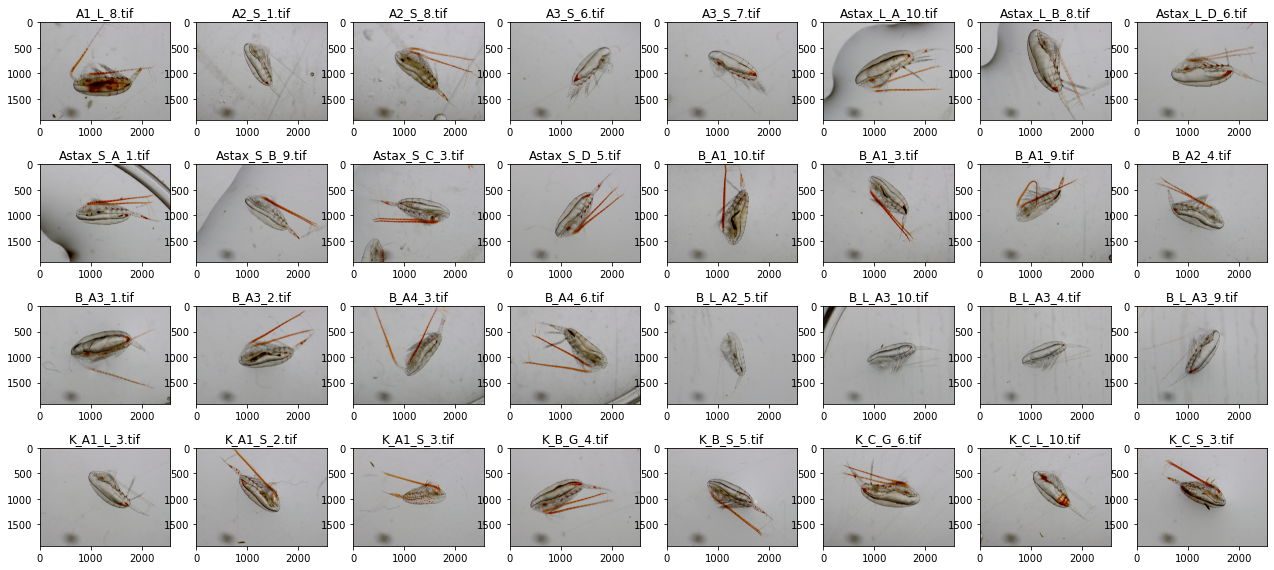

Average final RGB value: 165.5698405795627 , standard deviation: 2.606945947321567 , median: 165.82489705403646


In [9]:
# Visualize
imgs_calib_list = os.listdir("imgs_processed/test2/dataset1_calibrated/")
imgs_calib_list.sort() # sort images to visualize them in the same order
final_RGB = [] #list with final images arrays

print("Calibrated images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows):
    filename = "imgs_processed/test2/dataset1_calibrated/" + imgs_calib_list[i]
    img = io.imread(filename)
    final_RGB.append(np.mean(img, axis=(0,1))) # stock the RGB calibrated values in a list
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    plt.imshow(img)
plt.show()
print("Average final RGB value:", np.mean(final_RGB), ", standard deviation:", np.std(final_RGB), ", median:", np.median(final_RGB))

<br/>
The average RGB value has changed from 166.2 to 165.6 and the **standard deviation of this value has changed from 19.5 to 2.6, so calibration appears correct.**

In [14]:
# Test on one image to display RGB color distribution
#imgs_list = os.listdir("imgs_test/dataset1/") # all images to read
#imgs_list.sort() # sort images to visualize them in the same order
#img_test = io.imread("imgs_test/dataset1/" + imgs_list[9])
#plt.imshow(img_test[:,:,0]) #example of the red canal 
#plt.imshow(img_test) #example of the red canal 
#plt.show()
#display(np.mean(img_test, axis=(0)))
#display(np.mean(img_test, axis=(0,1))) # mean of distinct R, G and B intensities on the image > list of 3 values
#display(np.mean(img_test, axis=(0,1,2))) # display(np.mean(img_test)) : mean of total R, G and B intensisties over all pixels > only one value

# Plot histogram of RGB values in one image
#plt.xlim(0,250)
#n, bins, patches = plt.hist(img_test[:,:,0], 30, facecolor='r', alpha=0.75)

#plt.xlim(0,250)
#n, bins, patches = plt.hist(img_test[:,:,1], 30, facecolor='g', alpha=0.75)

#plt.xlim(0,250)
#n, bins, patches = plt.hist(img_test[:,:,2], 30, facecolor='b', alpha=0.75)

# 2. Identify red pixels with the color deconvolution method 
    - Construct color deconvolution matrix [x]
    - Apply it on all calibrated images [x]
    - Display astaxanthin optical density values and save images [x]

# 2.1. Construct deconvolution matrix 

### First try with initial RGB values for astaxanthin from a copepod' image 

In [16]:
# Optical Density (OD) matrix : 
rgb_from_stains = np.array([
    [0.51, 0.11, 0.06], # RGB astaxanthin
    # Background
    [1, 1, 1],
    # Placeholder
    [0,0,0]])

# Calculate residuals = normalize the OD matrix: 
rgb_from_stains[2, :] = np.cross(rgb_from_stains[0, :], rgb_from_stains[1, :])
display("normalized OD matrix :", rgb_from_stains)

# Calculate matrix inverse with linalg.inv :
stains_from_rgb = linalg.inv(rgb_from_stains)
display("inversed OD matrix = color deconvolution matrix:", stains_from_rgb)


'normalized OD matrix :'

array([[ 0.51,  0.11,  0.06],
       [ 1.  ,  1.  ,  1.  ],
       [ 0.05, -0.45,  0.4 ]])

'inversed OD matrix = color deconvolution matrix:'

array([[ 2.32876712, -0.19452055,  0.1369863 ],
       [-0.95890411,  0.55068493, -1.23287671],
       [-1.36986301,  0.64383562,  1.09589041]])

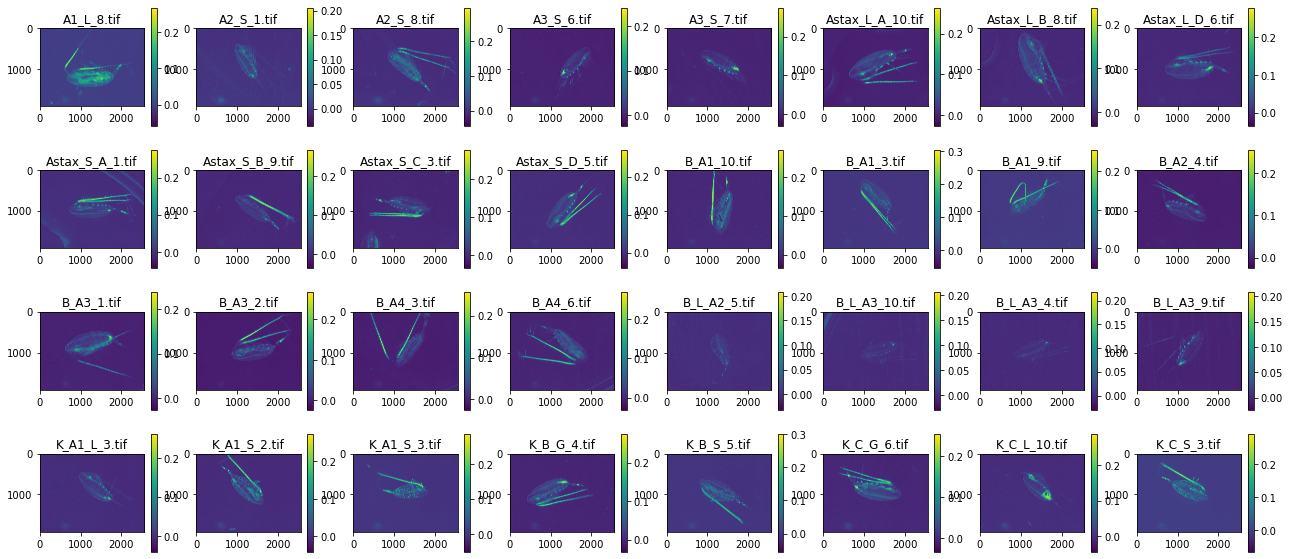

In [17]:
# Apply it on calibrated images 
imgs_calib_list = os.listdir("imgs_processed/test2/dataset1_calibrated") # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order

    
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_list)):
    filename_calibrated = "imgs_processed/test2/dataset1_calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    stains = separate_stains(img_calib, stains_from_rgb) # Extract stains 
    red = stains[...,0]# RGB to stain color space conversion (sickit image)
    # threshold using intensities histogramm on the image 
    thr = threshold_otsu(red, nbins=50)
    #display(thr)
    red_mask = red < (thr)# red mask :
    
    # Show on original image
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][red_mask] = 255
    img_highlight[:,:,1][red_mask] = 255
    img_highlight[:,:,2][red_mask] = 255
    io.imsave("imgs_processed/test2/dataset1_colordeconv1/" + imgs_calib_list[i] + "_deconv.jpg", img_highlight)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    low, high = np.quantile(-red, (.0, 1))
    plt.imshow(-red, vmin=low, vmax = high)
    plt.colorbar()
plt.show()

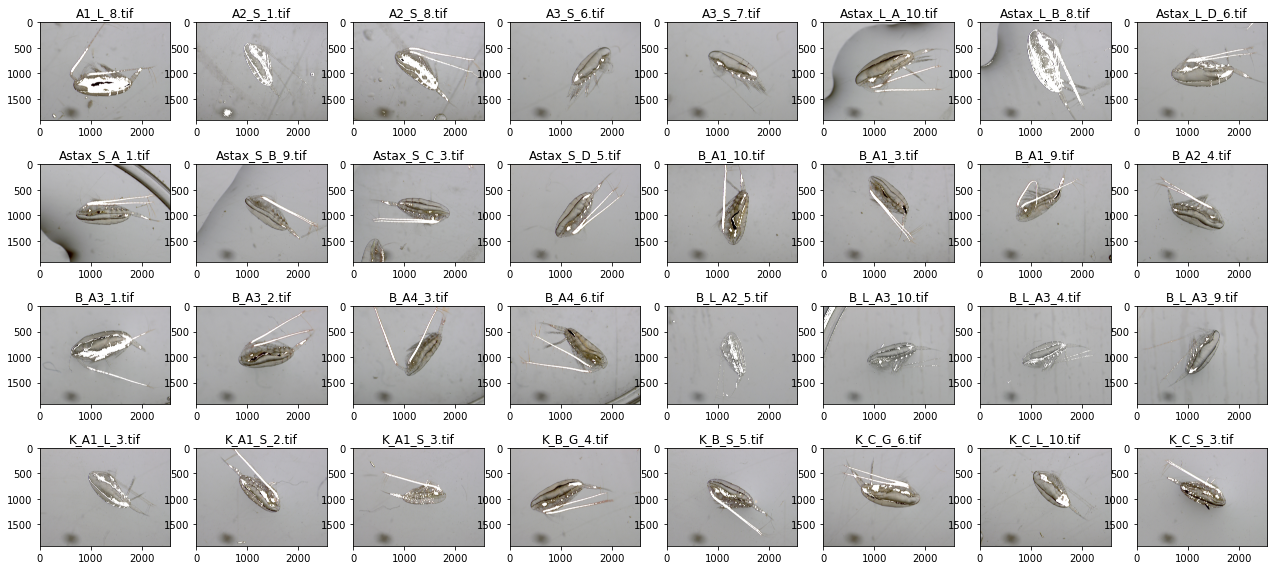

In [19]:
# Display images with red pixels identified
imgs_list = os.listdir("imgs_processed/test2/dataset1_colordeconv1/") # for now, we are taking calibrated images with the first calibration method 
imgs_list.sort() # sort images to visualize them in the same order

w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_list)):
    filename = "imgs_processed/test2/dataset1_colordeconv1/" + imgs_list[i]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    plt.imshow(img)
plt.show()

### Second try with RGB values for astaxanthin from the literature:
Bent Rønsholdt und Ewen Mclean, „Determination of Total Carotenoid Content in Rainbow Trout Muscle by Multivariate Calibration of VIS Reflectance Spectra“, Journal of Food Composition and Analysis - J FOOD COMPOS ANAL 14 (1. August 2001): 345–57, https://doi.org/10.1006/jfca.2000.0980.

In [228]:
rgb_from_stains2 = np.array([
    # RDG value from literature 
    [1.        ,  0.68396032,  0.6330574],
    # White
    [1, 1, 1],
    # Placeholder for third color
    [0,0,0]])
# Calculate residuals = normalize the OD matrix: 
rgb_from_stains2[2, :] = np.cross(rgb_from_stains2[0, :], rgb_from_stains2[1, :])
display("2nd try : normalized OD matrix :", rgb_from_stains2)

# Calculate matrix inverse with linalg.inv :
stains_from_rgb2 = linalg.inv(rgb_from_stains2)
display("2nd try: inversed OD matrix = color deconvolution matrix:", stains_from_rgb2)


'2nd try : normalized OD matrix :'

array([[ 1.        ,  0.68396032,  0.6330574 ],
       [ 1.        ,  1.        ,  1.        ],
       [ 0.05090292, -0.3669426 ,  0.31603968]])

'2nd try: inversed OD matrix = color deconvolution matrix:'

array([[ 2.88033482, -1.89126227,  0.21467241],
       [-1.11815879,  1.19693125, -1.54750362],
       [-1.76217603,  1.69433103,  1.3328312 ]])

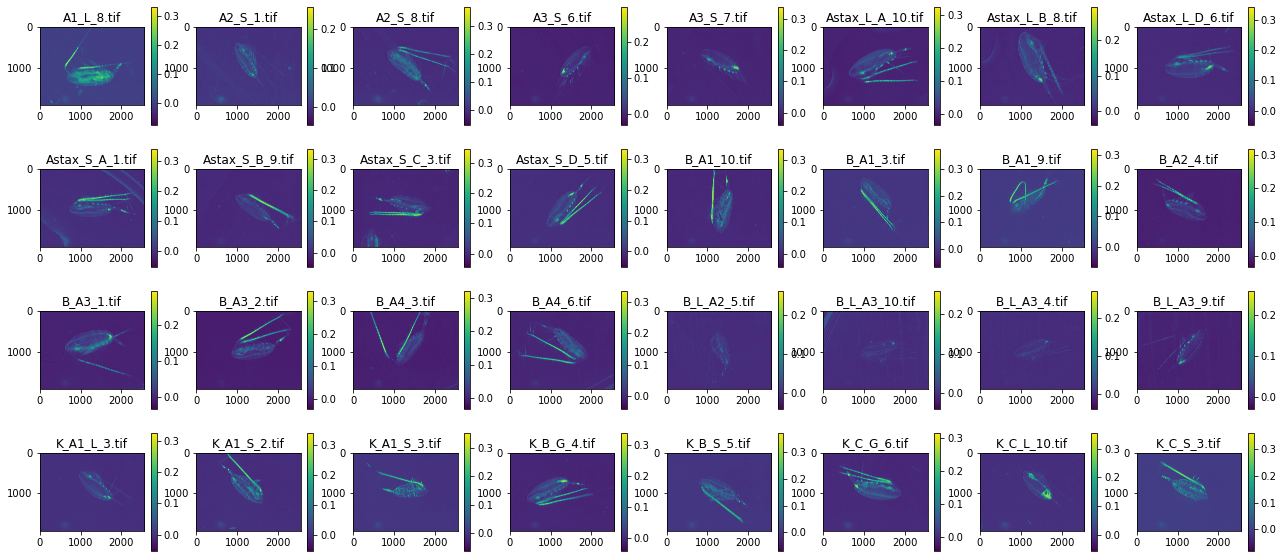

In [22]:
imgs_calib_list = os.listdir("imgs_processed/test2/dataset1_calibrated") # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order

    
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_list)):
    filename_calibrated = "imgs_processed/test2/dataset1_calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    stains = separate_stains(img_calib, stains_from_rgb2) # Extract stains 
    red = stains[...,0]# RGB to stain color space conversion (sickit image)
    # threshold using intensities histogramm on the image 
    thr = threshold_otsu(red, nbins=50)
    #display(thr)
    red_mask = red < thr # red mask :
    
    # Show on original image
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][red_mask] = 255
    img_highlight[:,:,1][red_mask] = 255
    img_highlight[:,:,2][red_mask] = 255
    io.imsave("imgs_processed/test2/dataset1_colordeconv2/" + imgs_calib_list[i] + "_deconv.jpg", img_highlight)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    low, high = np.quantile(-red, (.0, 1))
    plt.imshow(-red, vmin=low, vmax = high)
    plt.colorbar()
plt.show()

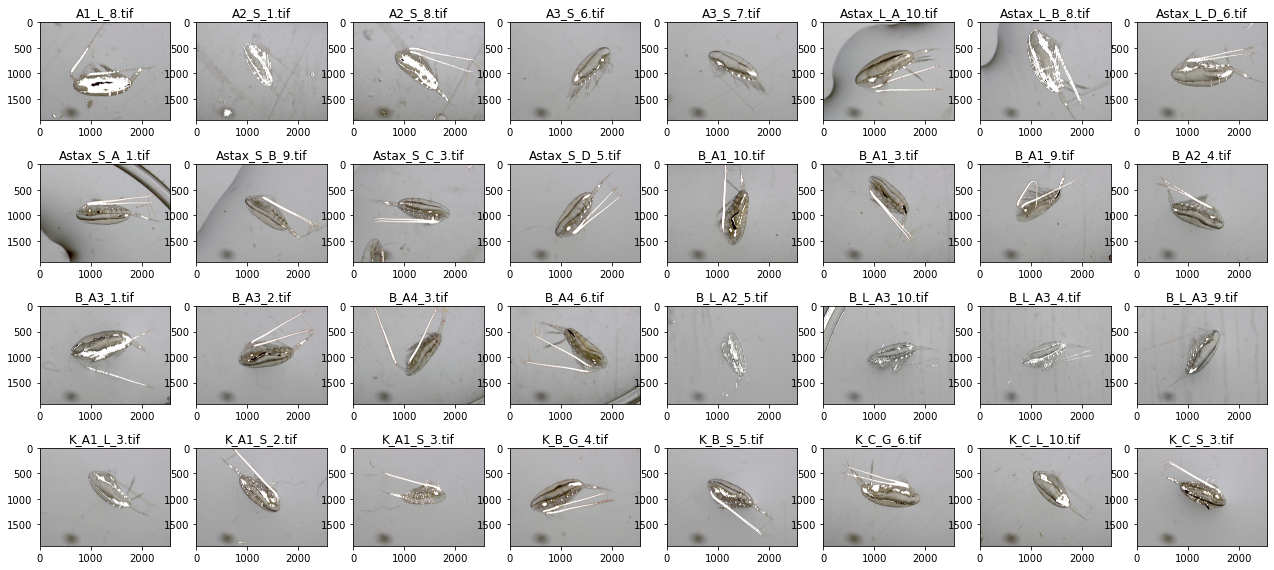

In [23]:
# 2.2 Display images with red pixels identified
imgs_list = os.listdir("imgs_processed/test2/dataset1_colordeconv2/") # for now, we are taking calibrated images with the first calibration method 
imgs_list.sort() # sort images to visualize them in the same order

w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_list)):
    filename = "imgs_processed/test2/dataset1_colordeconv2/" + imgs_list[i]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    plt.imshow(img)
plt.show()

Results are really close. Values [1., 0.68396032, 0.6330574] normalised between 0 and 1 are [0.43 0.29, 0.27], which is quite similar to the initial [0.51, 0.11 and 0.06]. But not so close at the same time: it looks not really sensitive, maybe we could test this sensibility. 

Red pixels are found even in images were there are absent, because of the moving otsu threshold (a threshold will always be found. So we will normalize astaxanthin optical density between 0 and 1, to then take a fixed threshold. 

# 3. Normalise optical density (OD) levels and use a fixed threshold
    - Compute max and min OD levels accross all tested images [X]
    - Correct  obtain a value between 0 and 1 [X]
    - Find a threshold and identify red pixels [X]
    - Display and save images [X]

Original astaxanthin OD levels


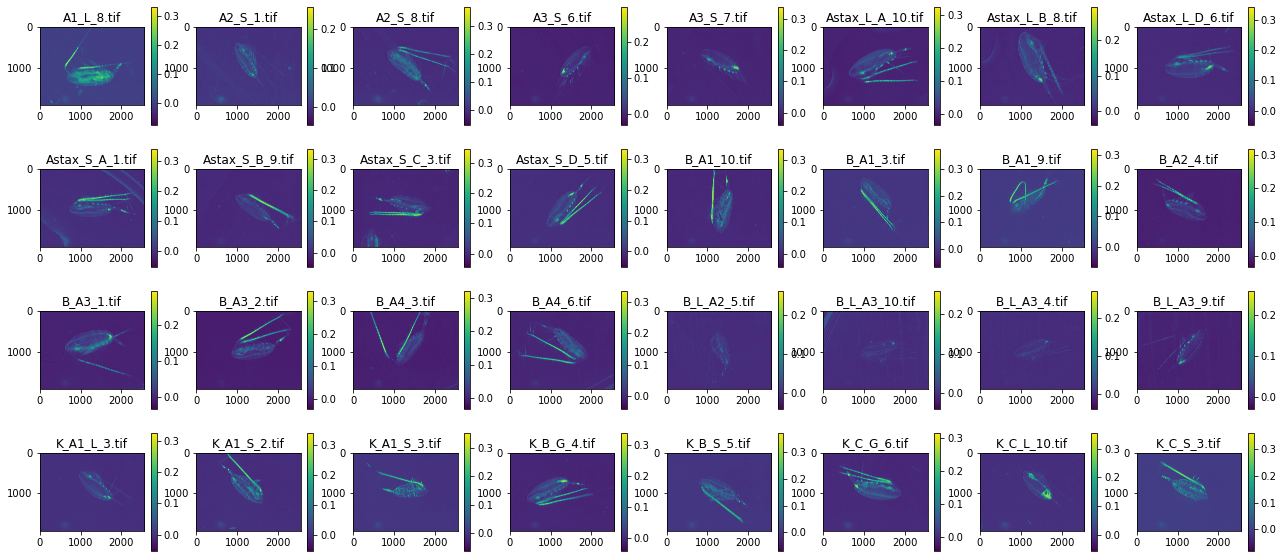

min = -0.07999855753840561 , max = 0.3744961276218289


In [229]:
# Apply it on calibrated images 
imgs_calib_list = os.listdir("imgs_processed/test2/dataset1_calibrated") # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order
asta_OD_imgs_list = [ ]

print("Original astaxanthin OD levels")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_calib_list)):
    filename_calibrated = "imgs_processed/test2/dataset1_calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    stains = separate_stains(img_calib, stains_from_rgb2) # Extract stains 
    red = -stains[...,0]# RGB to stain color space conversion (sickit image)
    asta_OD_imgs_list.append(red)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    low, high = np.quantile(red, (.0, 1))
    plt.imshow(red, vmin=low, vmax = high)
    plt.colorbar()
plt.show()
print("min =", np.min(asta_OD_imgs_list), ", max =", np.max(asta_OD_imgs_list))

Normalised astaxanthin OD levels between 0 and 1


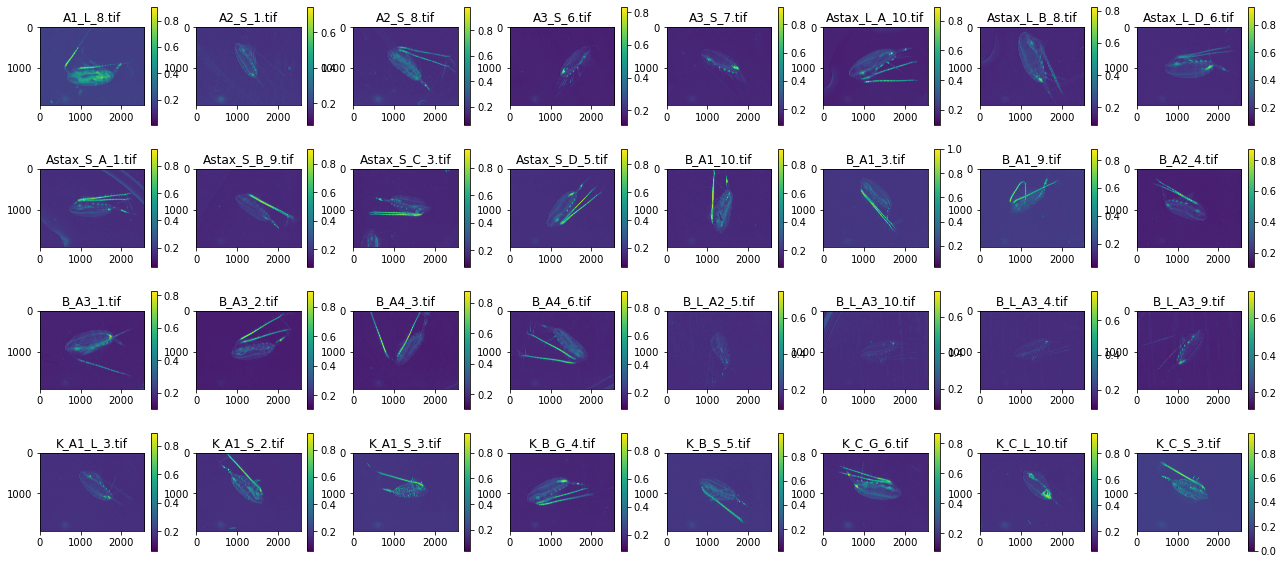

min = 0.0 max = 1.0


In [29]:
imgs_norm_list = [ ]

print("Normalised astaxanthin OD levels between 0 and 1")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_calib_list)):
    img = asta_OD_imgs_list[i]
    # threshold using intensities histogramm on the image 
    img_norm = (img + np.absolute(np.min(asta_OD_min))) / (np.max(asta_OD_max) + np.absolute(np.min(asta_OD_min)))
    imgs_norm_list.append(img_norm)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    #low, high = np.quantile(img_norm, (.0, 1))
    plt.imshow(img_norm, vmin=0.2, vmax = 0.6)
    plt.colorbar()
    
plt.show()
print("min =", np.min(imgs_norm_list), "max =", np.max(imgs_norm_list))

In [ ]:
plt.title(imgs_names[13])
low, high = np.quantile(imgs_norm_list[13], (.0, 1))
plt.imshow(imgs_norm_list[13], vmin=low, vmax = high)
plt.colorbar()
plt.show()

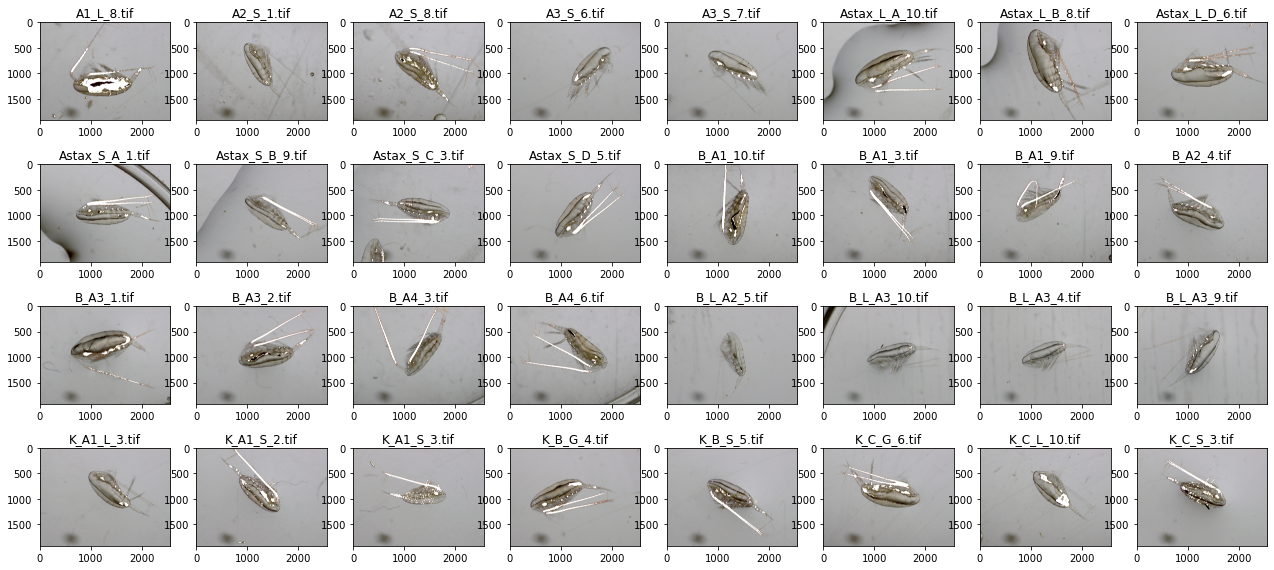

'mean otsu threshold is :'

0.33288629286412286

In [36]:
imgs_calib_list = os.listdir("imgs_processed/test2/dataset1_calibrated") # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order
thr_otsu_list = [ ]

w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_norm_list)):
    filename_calibrated = "imgs_processed/test2/dataset1_calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    
    red =  imgs_norm_list[i]
    thr_otsu = threshold_otsu(red, nbins=50)# threshold using intensities histogramm on the image 
    thr_otsu_list.append(thr_otsu)
    thr = 0.40
    red_mask = red > thr # red mask :
    
    # Show on original image
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][red_mask] = 255
    img_highlight[:,:,1][red_mask] = 255
    img_highlight[:,:,2][red_mask] = 255
    io.imsave("imgs_processed/test2/dataset1_colordeconv3/" + imgs_calib_list[i] + "_deconv.jpg", img_highlight)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.title(imgs_names[i])
    plt.imshow(img_highlight)
plt.show()
display("mean otsu threshold is :", np.mean(thr_otsu_list))